<a href="https://colab.research.google.com/github/mickeykubo/analytics_book/blob/master/prophet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PM2.5の予測を例として、Facebook Prophet, Scikit Learn (Random Forest), fast.ai (Tabular Model)を比較する。


In [1]:
!pip install fastai

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np

In [0]:
from fastai import *
from fastai.tabular import *

In [4]:
prsa = pd.read_csv("http://logopt.com/data/PRSA.csv")
prsa.dropna(inplace=True)
prsa["pmlog"] = np.log(prsa["pm2.5"]+0.001)
prsa.head()

No  year  month  day  hour  pm2.5  ...    PRES  cbwd   Iws Is  Ir     pmlog
24  25  2010      1    2     0  129.0  ...  1020.0    SE  1.79  0   0  4.859820
25  26  2010      1    2     1  148.0  ...  1020.0    SE  2.68  0   0  4.997219
26  27  2010      1    2     2  159.0  ...  1021.0    SE  3.57  0   0  5.068910
27  28  2010      1    2     3  181.0  ...  1022.0    SE  5.36  1   0  5.198503
28  29  2010      1    2     4  138.0  ...  1022.0    SE  6.25  2   0  4.927261

[5 rows x 14 columns]

ヒストグラムを表示してみると、裾野が
広い分布をしている。正規分布に近くなるよいうに、何らかの変換をしておくことが推奨される。上では、対数をとっている。

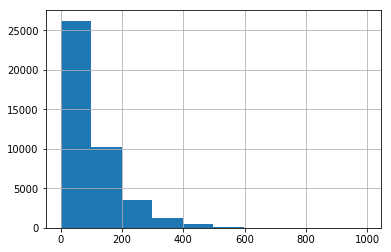

In [0]:
# See the histgram that has a long tail 
prsa["pm2.5"].hist()

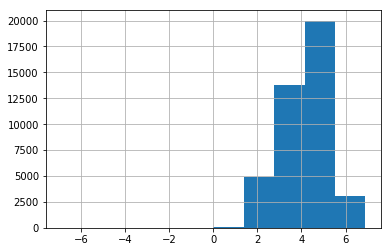

In [0]:
# Take a log makes a normal distribution
prsa["pmlog"].hist()

In [0]:
#The Box-Cox transform is given by:
#
#y = (x**lmbda - 1) / lmbda,  for lmbda > 0
#    log(x),                  for lmbda = 0

from scipy import stats
prsa["pmboxcox"], lmbda = stats.boxcox(prsa["pm2.5"]+0.001)

0.16210311963067547

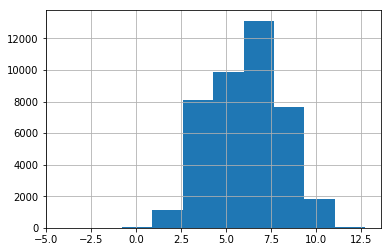

In [0]:
prsa["pmboxcox"].hist()
lmbda

[Rf3e1504535de-1]	I.K. Yeo and R.A. Johnson, “A new family of power transformations to improve normality or symmetry.” Biometrika, 87(4), pp.954-959, (2000).
[Rf3e1504535de-2]	G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964).

PowerTransformerの既定値はYao-Johnson法（負の値もOK)

The Yeo-Johnson transform is given by:

```
y = ((x + 1)**lmbda - 1) / lmbda,                for x >= 0, lmbda != 0
    log(x + 1),                                  for x >= 0, lmbda = 0
    -((-x + 1)**(2 - lmbda) - 1) / (2 - lmbda),  for x < 0, lmbda != 2
    -log(-x + 1),                                for x < 0, lmbda = 2
```

SciPy does not support "reverse" transformation.  We use scikit learn below.

In [0]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
data = prsa["pm2.5"].values.reshape(-1,1)
pt.fit( data )
print(pt.lambdas_)
prsa["pmyeo"] = pt.transform(data)

[0.141749]


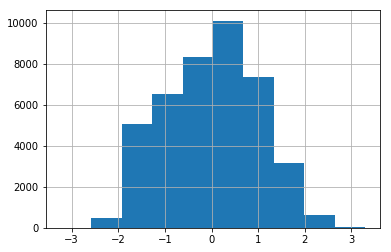

In [0]:
prsa["pmyeo"].hist()

In [0]:
# reverse transformation 
original = pt.inverse_transform(prsa["pmyeo"].values.reshape(-1,1))
original

array([[129.],
       [148.],
       [159.],
       [181.],
       ...,
       [ 10.],
       [ 10.],
       [  8.],
       [ 12.]])

In [0]:
data

array([[129.],
       [148.],
       [159.],
       [181.],
       ...,
       [ 10.],
       [ 10.],
       [  8.],
       [ 12.]])

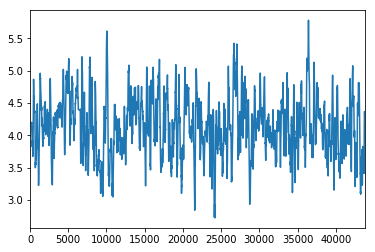

In [0]:
prsa["pmlog"].rolling(24*7).mean().plot()

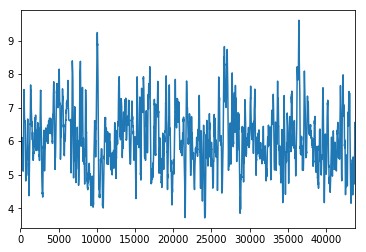

In [0]:
prsa["pmboxcox"].rolling(24*7).mean().plot()

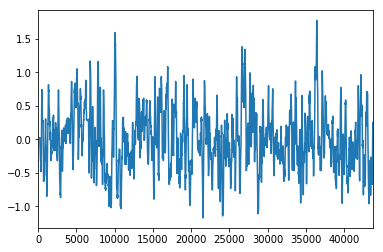

In [0]:
prsa["pmyeo"].rolling(24*7).mean().plot()

In [0]:
prsa.head()

No  year  month  day  hour  ...  Is  Ir     pmlog  pmboxcox     pmyeo
24  25  2010      1    2     0  ...   0   0  4.859820  7.393668  0.673892
25  26  2010      1    2     1  ...   0   0  4.997219  7.699134  0.826911
26  27  2010      1    2     2  ...   0   0  5.068910  7.861240  0.907994
27  28  2010      1    2     3  ...   1   0  5.198503  8.159093  1.056747
28  29  2010      1    2     4  ...   2   0  4.927261  7.542753  0.748611

[5 rows x 16 columns]

In [0]:
prsa.dtypes

No            int64
year          int64
month         int64
day           int64
hour          int64
pm2.5       float64
DEWP          int64
TEMP        float64
PRES        float64
cbwd         object
Iws         float64
Is            int64
Ir            int64
pmlog       float64
pmboxcox    float64
pmyeo       float64
dtype: object

In [0]:
!pip install fbprophet

In [0]:
import pandas as pd
import numpy as np
prsa = pd.read_csv("http://logopt.com/data/PRSA.csv")
prsa.dropna(inplace=True)
prsa["pmlog"] = np.log(prsa["pm2.5"]+0.001)
prsa.head()

No  year  month  day  hour  pm2.5  ...    PRES  cbwd   Iws Is  Ir     pmlog
24  25  2010      1    2     0  129.0  ...  1020.0    SE  1.79  0   0  4.859820
25  26  2010      1    2     1  148.0  ...  1020.0    SE  2.68  0   0  4.997219
26  27  2010      1    2     2  159.0  ...  1021.0    SE  3.57  0   0  5.068910
27  28  2010      1    2     3  181.0  ...  1022.0    SE  5.36  1   0  5.198503
28  29  2010      1    2     4  138.0  ...  1022.0    SE  6.25  2   0  4.927261

[5 rows x 14 columns]

In [0]:
#prsa = pd.read_csv("PRSA.csv")
#prsa.dropna(inplace=True)
prsa["datetime"] = prsa.year.astype(str) + "-" + prsa.month.astype(str) + "-"+prsa.day.astype(str)+" "+prsa.hour.astype(str)+":00:00"
prsa["datetime"] = pd.to_datetime(prsa.datetime)

In [0]:
prsa.set_index("datetime", inplace=True)
prsa.head()

No  year  month  day  hour  ...  cbwd   Iws  Is  Ir     pmlog
datetime                                         ...                              
2010-01-02 00:00:00  25  2010      1    2     0  ...    SE  1.79   0   0  4.859820
2010-01-02 01:00:00  26  2010      1    2     1  ...    SE  2.68   0   0  4.997219
2010-01-02 02:00:00  27  2010      1    2     2  ...    SE  3.57   0   0  5.068910
2010-01-02 03:00:00  28  2010      1    2     3  ...    SE  5.36   1   0  5.198503
2010-01-02 04:00:00  29  2010      1    2     4  ...    SE  6.25   2   0  4.927261

[5 rows x 14 columns]

In [0]:
prsa.describe()

No          year  ...            Ir         pmlog
count  41757.000000  41757.000000  ...  41757.000000  41757.000000
mean   22279.380104   2012.042771  ...      0.194866      4.135284
std    12658.168415      1.415311  ...      1.418165      1.036385
min       25.000000   2010.000000  ...      0.000000     -6.907755
25%    11464.000000   2011.000000  ...      0.000000      3.367330
50%    22435.000000   2012.000000  ...      0.000000      4.276680
75%    33262.000000   2013.000000  ...      0.000000      4.919988
max    43824.000000   2014.000000  ...     36.000000      6.901738

[8 rows x 13 columns]

In [0]:
#df_input = prsa.reset_index().rename(columns={'datetime':'ds', 'pmlog':'y'})

In [0]:
#df_input = prsa.reset_index().rename(columns={'datetime':'ds', 'pmboxcox':'y'})
df_input = prsa.reset_index().rename(columns={'datetime':'ds', 'pmlog':'y'})
#df_input = prsa.reset_index().rename(columns={'datetime':'ds', 'pm2.5':'y'})

In [0]:
from fbprophet import Prophet
#model = Prophet(growth='linear', daily_seasonality=True, seasonality_mode="multiplicative")
model = Prophet(growth='linear',changepoint_prior_scale=0.01)
#model.add_seasonality(name='daily', period=30.5, fourier_order=5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_input[:-2000])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

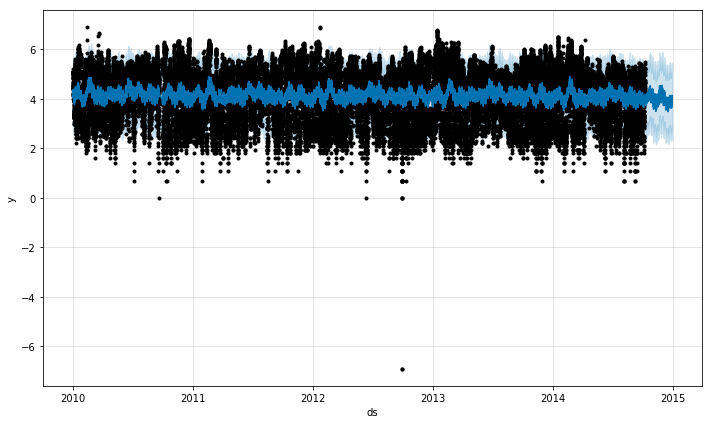

In [0]:
future = model.make_future_dataframe(periods=2000, freq='H')
forecast = model.predict(future)
model.plot(forecast)
plt.show()

In [0]:
prsa["forecast"] = forecast["yhat"].values

In [0]:
#forecast["yhat"].head()
prsa["forecast"].head()

datetime
2010-01-02 00:00:00    4.306661
2010-01-02 01:00:00    4.305064
2010-01-02 02:00:00    4.293117
2010-01-02 03:00:00    4.263412
2010-01-02 04:00:00    4.223315
Name: forecast, dtype: float64

In [0]:
# reverse transformation 
prsa["forecast"] = pt.inverse_transform(forecast.yhat.values.reshape(-1,1))

In [0]:
forecast.head()

ds     trend  ...  multiplicative_terms_upper      yhat
0 2010-01-02 00:00:00  4.169318  ...                         0.0  4.306661
1 2010-01-02 01:00:00  4.169323  ...                         0.0  4.305064
2 2010-01-02 02:00:00  4.169329  ...                         0.0  4.293117
3 2010-01-02 03:00:00  4.169334  ...                         0.0  4.263412
4 2010-01-02 04:00:00  4.169339  ...                         0.0  4.223315

[5 rows x 25 columns]

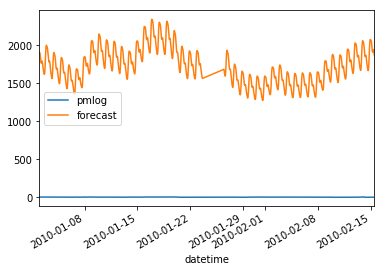

In [0]:
prsa[ ["pmlog", "forecast"]][:1000].plot()

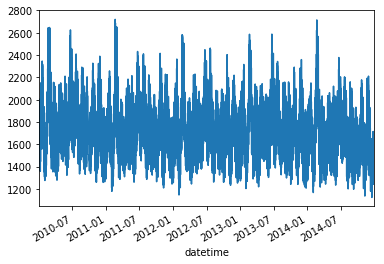

In [0]:
prsa["forecast"].plot()

In [0]:
 ((forecast.yhat[-2000:]  - df_input["y"][-2000:])**2).mean() 

1.6194018644403294

In [0]:
 ((forecast.yhat[-2000:]  - df_input["y"][-2000:])**2).mean() 

1.6194018644403294

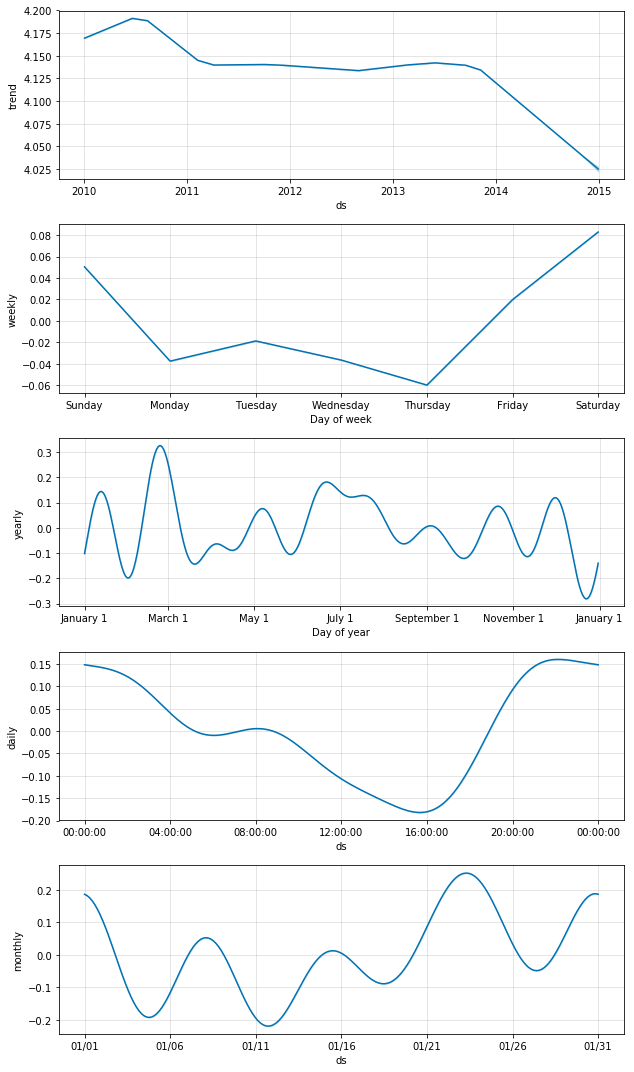

In [0]:
model.plot_components(forecast)
plt.show()

ランダム森で予測

In [0]:
import pandas as pd
import numpy as np
prsa = pd.read_csv("http://logopt.com/data/PRSA.csv")
prsa.dropna(inplace=True)
prsa["pmlog"] = np.log(prsa["pm2.5"]+0.001)
prsa.head()

No  year  month  day  hour  pm2.5  ...    PRES  cbwd   Iws Is  Ir     pmlog
24  25  2010      1    2     0  129.0  ...  1020.0    SE  1.79  0   0  4.859820
25  26  2010      1    2     1  148.0  ...  1020.0    SE  2.68  0   0  4.997219
26  27  2010      1    2     2  159.0  ...  1021.0    SE  3.57  0   0  5.068910
27  28  2010      1    2     3  181.0  ...  1022.0    SE  5.36  1   0  5.198503
28  29  2010      1    2     4  138.0  ...  1022.0    SE  6.25  2   0  4.927261

[5 rows x 14 columns]

In [0]:
prsa2 = pd.get_dummies(prsa, drop_first=True) #ダミー変数の最初のものを除く
prsa2.head()

No  year  month  day  hour  ...  Ir     pmlog  cbwd_NW  cbwd_SE  cbwd_cv
24  25  2010      1    2     0  ...   0  4.859820        0        1        0
25  26  2010      1    2     1  ...   0  4.997219        0        1        0
26  27  2010      1    2     2  ...   0  5.068910        0        1        0
27  28  2010      1    2     3  ...   0  5.198503        0        1        0
28  29  2010      1    2     4  ...   0  4.927261        0        1        0

[5 rows x 16 columns]

In [0]:
train_df = prsa2.iloc[ :-2000, :]

In [0]:
test_df = prsa2.iloc[-2000: , :]

In [0]:
X_train = train_df.drop(["pm2.5","pmlog","No"], axis=1)
X_train.head()

year  month  day  hour  DEWP  TEMP  ...   Iws  Is  Ir  cbwd_NW  cbwd_SE  cbwd_cv
24  2010      1    2     0   -16  -4.0  ...  1.79   0   0        0        1        0
25  2010      1    2     1   -15  -4.0  ...  2.68   0   0        0        1        0
26  2010      1    2     2   -11  -5.0  ...  3.57   0   0        0        1        0
27  2010      1    2     3    -7  -5.0  ...  5.36   1   0        0        1        0
28  2010      1    2     4    -7  -5.0  ...  6.25   2   0        0        1        0

[5 rows x 13 columns]

In [0]:
y_train = train_df["pmlog"]
y_train.head()

24    4.859820
25    4.997219
26    5.068910
27    5.198503
28    4.927261
Name: pmlog, dtype: float64

In [0]:
X_test = test_df.drop(["pm2.5","pmlog","No"], axis=1)
y_test = test_df["pmlog"]

In [0]:
from sklearn.ensemble import RandomForestRegressor #ランダム森
from sklearn import tree
forest = RandomForestRegressor(n_estimators=100,min_samples_leaf=5,oob_score=True,max_depth=4)
#forest = tree.DecisionTreeRegressor(max_depth=2)
forest.fit(X_train, y_train)    # 学習
yhat = forest.predict(X_test)   # 予測

In [0]:
from sklearn.metrics import mean_squared_error
np.sqrt( mean_squared_error(y_test,yhat) )

0.999879466537739

In [0]:
# https://qiita.com/calderarie/items/e4321bff95ac3042601b
!pip install dtreeviz


  Stored in directory: /root/.cache/pip/wheels/f5/a9/98/36f14337796dffe1f838479fbf4c5feeff282a1a01f5688dd6
Successfully built dtreeviz


In [0]:
# Extract single tree
estimator =forest.estimators_[0]
estimator

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=3021750, splitter='best')

In [0]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(
    estimator,
    #forest,
    X_train, 
    y_train,
    target_name="pmlog",
    feature_names= X_train.columns,
    fancy=False
) 

#viz.view()

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [0]:
display(viz)

In [0]:
#!sudo apt install graphviz
!pip install rfpimp

  Stored in directory: /root/.cache/pip/wheels/c7/35/67/4065afd69df4c0be693ecdec8a9c1433a23f80ee60395272ba
Successfully built rfpimp


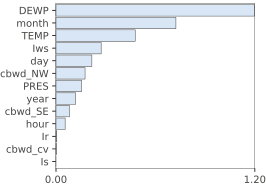

In [0]:
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100,min_samples_leaf=5,oob_score=True)
forest.fit(X_train, y_train)    # 学習
imp = importances(forest, X_train, y_train, n_samples=-1)
viz = plot_importances(imp)
viz

In [0]:
forest.score(X_test,y_test)

0.7143365020407765

In [0]:
df = pd.DataFrame( {"ytest":y_test, "yhat":yhat} )
             

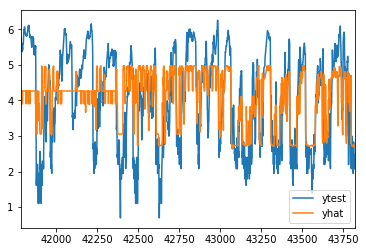

In [0]:
df.plot()

日時をそのままカテゴリーデータとした深層学習

In [0]:
prsa = pd.read_csv("http://logopt.com/data/PRSA.csv")
prsa.dropna(inplace=True)
prsa["pmlog"] = np.log(prsa["pm2.5"]+0.001)
prsa.head()

No  year  month  day  hour  pm2.5  ...    PRES  cbwd   Iws Is  Ir     pmlog
24  25  2010      1    2     0  129.0  ...  1020.0    SE  1.79  0   0  4.859820
25  26  2010      1    2     1  148.0  ...  1020.0    SE  2.68  0   0  4.997219
26  27  2010      1    2     2  159.0  ...  1021.0    SE  3.57  0   0  5.068910
27  28  2010      1    2     3  181.0  ...  1022.0    SE  5.36  1   0  5.198503
28  29  2010      1    2     4  138.0  ...  1022.0    SE  6.25  2   0  4.927261

[5 rows x 14 columns]

In [0]:
prsa.drop(["pm2.5","No"], axis=1, inplace=True)
procs = [FillMissing, Categorify, Normalize] #前処理の種類を準備．
valid_idx = range(len(prsa)-2000, len(prsa)) #検証用データのインデックスを準備．
dep_var = 'pmlog' #従属変数名とカテゴリー変数が格納されている列リストを準備．
# DataBunchのインスタンスdataを生成．
data = TabularDataBunch.from_df(".", prsa, dep_var, valid_idx=valid_idx, procs=procs, 
                                cat_names=["year", "month", "day", "hour", "DEWP", "cbwd","Is","Ir"])
prsa.head()

year  month  day  hour  DEWP  TEMP    PRES cbwd   Iws  Is  Ir     pmlog
24  2010      1    2     0   -16  -4.0  1020.0   SE  1.79   0   0  4.859820
25  2010      1    2     1   -15  -4.0  1020.0   SE  2.68   0   0  4.997219
26  2010      1    2     2   -11  -5.0  1021.0   SE  3.57   0   0  5.068910
27  2010      1    2     3    -7  -5.0  1022.0   SE  5.36   1   0  5.198503
28  2010      1    2     4    -7  -5.0  1022.0   SE  6.25   2   0  4.927261

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=root_mean_squared_error)
#learn.lr_find()
#learn = tabular_learner(data, layers=[1000,500],ps=[0.001,0.01], emb_drop=0.4, metrics=mean_squared_error)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


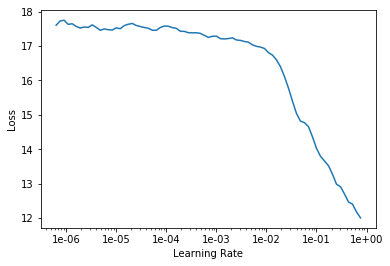

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-2, wd=.2)

In [0]:
learn

Learner(data=TabularDataBunch;

Train: LabelList (39757 items)
x: TabularList
year 2010; month 1; day 2; hour 0; DEWP -16; cbwd SE; Is 0; Ir 0; Iws -0.4487; TEMP -1.3668; PRES 0.3815; ,year 2010; month 1; day 2; hour 1; DEWP -15; cbwd SE; Is 0; Ir 0; Iws -0.4302; TEMP -1.3668; PRES 0.3815; ,year 2010; month 1; day 2; hour 2; DEWP -11; cbwd SE; Is 0; Ir 0; Iws -0.4118; TEMP -1.4484; PRES 0.4783; ,year 2010; month 1; day 2; hour 3; DEWP -7; cbwd SE; Is 1; Ir 0; Iws -0.3746; TEMP -1.4484; PRES 0.5751; ,year 2010; month 1; day 2; hour 4; DEWP -7; cbwd SE; Is 2; Ir 0; Iws -0.3561; TEMP -1.4484; PRES 0.5751; 
y: FloatList
4.8598204,4.997219,5.0689106,5.1985025,4.927261
Path: .;

Valid: LabelList (2000 items)
x: TabularList
year 2014; month 10; day 7; hour 21; DEWP 11; cbwd NE; Is 0; Ir 0; Iws -0.4674; TEMP -0.0617; PRES 0.2847; ,year 2014; month 10; day 7; hour 22; DEWP 11; cbwd cv; Is 0; Ir 0; Iws -0.4674; TEMP -0.0617; PRES 0.3815; ,year 2014; month 10; day 7; hour 23; DEWP 11; cbwd cv; Is

In [0]:
yhat=[]
for t in range(2000):
  yhat.append(  float(learn.predict(prsa.iloc[-2000+t] )[1]) )  

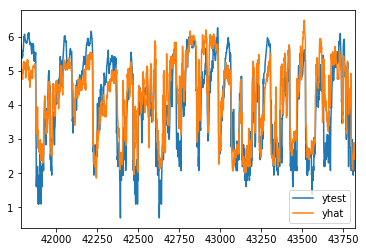

In [0]:
df = pd.DataFrame( {"ytest":y_test, "yhat":yhat} )
df.plot()


埋め込み層を用いた深層学習

add_datepart(df, fldname, drop=True, time=False)

In [0]:
prsa = pd.read_csv("http://logopt.com/data/PRSA.csv")
prsa.dropna(inplace=True)
prsa["pmlog"] = np.log(prsa["pm2.5"]+0.001)
prsa.head()

No  year  month  day  hour  pm2.5  ...    PRES  cbwd   Iws Is  Ir     pmlog
24  25  2010      1    2     0  129.0  ...  1020.0    SE  1.79  0   0  4.859820
25  26  2010      1    2     1  148.0  ...  1020.0    SE  2.68  0   0  4.997219
26  27  2010      1    2     2  159.0  ...  1021.0    SE  3.57  0   0  5.068910
27  28  2010      1    2     3  181.0  ...  1022.0    SE  5.36  1   0  5.198503
28  29  2010      1    2     4  138.0  ...  1022.0    SE  6.25  2   0  4.927261

[5 rows x 14 columns]

In [0]:
prsa["datetime"] = prsa.year.astype(str) + "-" + prsa.month.astype(str) + "-"+prsa.day.astype(str) #+" "+prsa.hour.astype(str)+":00:00"
prsa["datetime"] = pd.to_datetime(prsa.datetime)
prsa.head()

No  year  month  day  hour  pm2.5  ...  cbwd   Iws  Is Ir     pmlog   datetime
24  25  2010      1    2     0  129.0  ...    SE  1.79   0  0  4.859820 2010-01-02
25  26  2010      1    2     1  148.0  ...    SE  2.68   0  0  4.997219 2010-01-02
26  27  2010      1    2     2  159.0  ...    SE  3.57   0  0  5.068910 2010-01-02
27  28  2010      1    2     3  181.0  ...    SE  5.36   1  0  5.198503 2010-01-02
28  29  2010      1    2     4  138.0  ...    SE  6.25   2  0  4.927261 2010-01-02

[5 rows x 15 columns]

In [0]:
prsa.drop(["year", "month", "day","No"], axis=1, inplace=True)
prsa.head()

hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  Is  Ir     pmlog   datetime
24     0  129.0   -16  -4.0  1020.0   SE  1.79   0   0  4.859820 2010-01-02
25     1  148.0   -15  -4.0  1020.0   SE  2.68   0   0  4.997219 2010-01-02
26     2  159.0   -11  -5.0  1021.0   SE  3.57   0   0  5.068910 2010-01-02
27     3  181.0    -7  -5.0  1022.0   SE  5.36   1   0  5.198503 2010-01-02
28     4  138.0    -7  -5.0  1022.0   SE  6.25   2   0  4.927261 2010-01-02

In [0]:
prsa2 = add_datepart(prsa, "datetime", drop=True, time=False)
prsa2.head()

hour  pm2.5  ...  datetimeIs_year_start  datetimeElapsed
24     0  129.0  ...                  False       1262390400
25     1  148.0  ...                  False       1262390400
26     2  159.0  ...                  False       1262390400
27     3  181.0  ...                  False       1262390400
28     4  138.0  ...                  False       1262390400

[5 rows x 23 columns]

In [0]:
prsa2.dtypes

No                            int64
hour                          int64
pm2.5                       float64
DEWP                          int64
TEMP                        float64
PRES                        float64
cbwd                         object
Iws                         float64
Is                            int64
Ir                            int64
pmlog                       float64
datetimeYear                  int64
datetimeMonth                 int64
datetimeWeek                  int64
datetimeDay                   int64
datetimeDayofweek             int64
datetimeDayofyear             int64
datetimeIs_month_end           bool
datetimeIs_month_start         bool
datetimeIs_quarter_end         bool
datetimeIs_quarter_start       bool
datetimeIs_year_end            bool
datetimeIs_year_start          bool
datetimeElapsed               int64
dtype: object

In [0]:
prsa2.columns

Index(['No', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is',
       'Ir', 'pmlog', 'datetimeYear', 'datetimeMonth', 'datetimeWeek',
       'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeElapsed'],
      dtype='object')

In [0]:
cat_vars = ["cbwd","Is","Ir","hour", 'datetimeYear', 'datetimeMonth', 'datetimeWeek', 'datetimeDay',
       'datetimeDayofweek', 'datetimeDayofyear', 'datetimeIs_month_end',
       'datetimeIs_month_start', 'datetimeIs_quarter_end',
       'datetimeIs_quarter_start', 'datetimeIs_year_end',
       'datetimeIs_year_start']
cont_vars = list(set(prsa2.columns) - set(cat_vars) - {"No", "pm2.5","pmlog"}   )    
cont_vars

['Iws', 'PRES', 'TEMP', 'DEWP', 'datetimeElapsed']

In [0]:
procs = [FillMissing, Categorify, Normalize] #前処理の種類を準備．
valid_idx = range(len(prsa2)-2000, len(prsa2)) #検証用データのインデックスを準備．
dep_var = 'pmlog' #従属変数名とカテゴリー変数が格納されている列リストを準備．
# DataBunchのインスタンスdataを生成．
data = TabularDataBunch.from_df(".", prsa2, dep_var, valid_idx=valid_idx, procs=procs, 
                                cont_names=cont_vars,
                                cat_names= cat_vars )

In [0]:
#learn = tabular_learner(data, layers=[1000,500],ps=[0.001,0.01], emb_drop=0.04, metrics=mean_squared_error)
#learn = tabular_learner(data, layers=[1000,500],ps=[0.01,0.1], emb_drop=0.1, metrics=mean_squared_error)
learn = tabular_learner(data, layers=[200,100],ps=[0.01,0.1], emb_drop=0.1, metrics=mean_squared_error)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


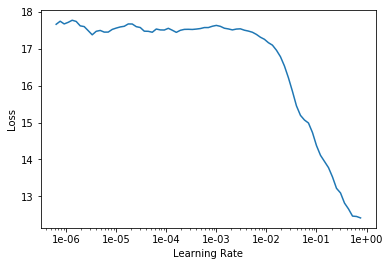

In [0]:
learn.recorder.plot()

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(29, 11)
    (2): Embedding(38, 12)
    (3): Embedding(6, 4)
    (4): Embedding(13, 7)
    (5): Embedding(54, 15)
    (6): Embedding(32, 11)
    (7): Embedding(8, 5)
    (8): Embedding(367, 44)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=137, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(

In [0]:
learn.fit_one_cycle(5, 1e-2, wd=0.2)

In [0]:
yhat=[]
for t in range(2000):
  yhat.append(  float(learn.predict(prsa.iloc[-2000+t] )[1]) )  

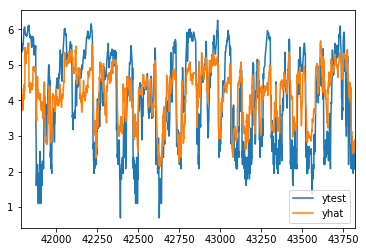

In [0]:
df = pd.DataFrame( {"ytest":y_test, "yhat":yhat} )
df.plot()

In [0]:
# データセットを読み込み
from sklearn.datasets import load_boston
boston = load_boston()
 
# 説明変数を Pandas のデータフレームとして表示
import pandas as pd
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head()

CRIM    ZN  INDUS  CHAS    NOX  ...  RAD    TAX  PTRATIO       B  LSTAT
0  0.00632  18.0   2.31   0.0  0.538  ...  1.0  296.0     15.3  396.90   4.98
1  0.02731   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  396.90   9.14
2  0.02729   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  392.83   4.03
3  0.03237   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  394.63   2.94
4  0.06905   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  396.90   5.33

[5 rows x 13 columns]